In [1]:
from pathlib import Path

root = Path(r"..\dataset\raw\data")

In [2]:
import pandas as pd

df_path = root / "train_solution_bounding_boxes (1).csv"
train_metadata = pd.read_csv(df_path)
train_metadata.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [3]:
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
train_image_folder = root / "training_images"


# display one image

def display_image_with_bounding_box(image, xmin, ymin, width, height):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(image)
    ax.add_patch(Rectangle((xmin,ymin), width, height, fc='none', lw=5, ec='r'))
    plt.axis('off')
    plt.show()


to plot using matplotlib, the bounding box xmin ymin width height

width = xmax - xmin,
height = ymax - ymin

In [4]:
row = train_metadata.to_dict('index')[10]
path = os.path.join(train_image_folder, row['image'])
image = plt.imread(path)
image

array([[[162, 214, 254],
        [161, 213, 253],
        [161, 213, 253],
        ...,
        [157, 201, 250],
        [157, 201, 250],
        [157, 201, 250]],

       [[162, 214, 254],
        [162, 214, 254],
        [162, 214, 254],
        ...,
        [157, 201, 250],
        [157, 201, 250],
        [158, 202, 251]],

       [[163, 215, 254],
        [162, 214, 253],
        [162, 214, 253],
        ...,
        [157, 201, 250],
        [158, 202, 251],
        [158, 202, 251]],

       ...,

       [[132, 100,  62],
        [130,  98,  60],
        [134, 102,  64],
        ...,
        [ 30,  46,  59],
        [ 29,  45,  58],
        [ 29,  45,  58]],

       [[135, 101,  66],
        [132,  98,  63],
        [134, 100,  63],
        ...,
        [ 32,  48,  61],
        [ 31,  47,  60],
        [ 30,  46,  59]],

       [[142, 106,  72],
        [136, 100,  66],
        [134, 100,  63],
        ...,
        [ 32,  48,  61],
        [ 30,  46,  59],
        [ 29,  45,  58]]

We are using Xception model as base model, so the input image has to be reshaped to (299, 299, 3)

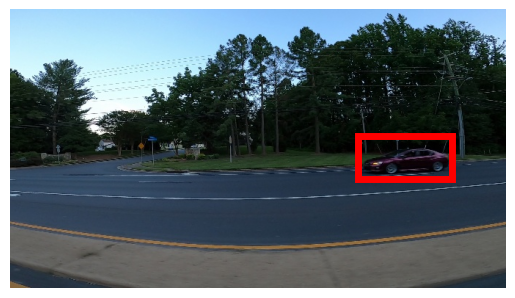

In [5]:
xmin = row['xmin']
ymin = row['ymin']
xmax = row['xmax']
ymax = row['ymax']
display_image_with_bounding_box(image, xmin, ymin, xmax-xmin, ymax-ymin)

the bounding box seems to be correctly align with the object

xmin and xmax will be in width and ymin ymax in height


find width and height scale and multiply with xmin, ymin, width, height

resize the image and bounding box to feed into the model.



In [6]:
import tensorflow as tf
preprocess_layer = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=299, width=299),
    tf.keras.layers.Rescaling(scale=1/255)
])

image_pre = preprocess_layer(image)

image_pre.shape

TensorShape([299, 299, 3])

In [7]:
original_width = image.shape[1]
original_height = image.shape[0]

In [8]:
WIDTH_SCALE = 299/ original_width
HEIGHT_SCALE = 299 / original_height

def preprocess_bounding_box(xmin, ymin, xmax, ymax):
    xmin_pro = xmin * WIDTH_SCALE
    y_min_pro = ymin * HEIGHT_SCALE
    xmax_pro = xmax * WIDTH_SCALE
    ymax_pro = ymax * HEIGHT_SCALE
    return [xmin_pro, y_min_pro, xmax_pro, ymax_pro]

WIDTH_SCALE, HEIGHT_SCALE

(0.4423076923076923, 0.7868421052631579)

In [9]:
x, y ,w, h = preprocess_bounding_box(xmin, ymin, xmax, ymax)
x, y ,w, h

(209.64616499423076, 136.0074806931579, 266.33068017884614, 181.80027348736843)

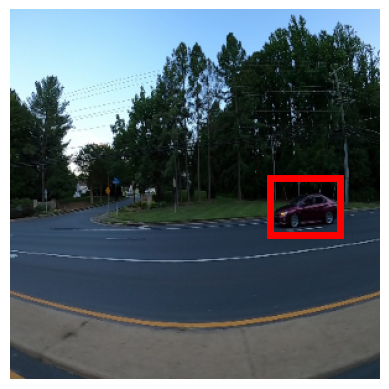

In [10]:
display_image_with_bounding_box(image_pre, x, y, w-x, h-y)

In [11]:
import glob
import numpy as np
import tensorflow as tf
from PIL import Image

create a pipeline like:
image_paths, (label, bounding box)

In [12]:
image_files = sorted(glob.glob(str(train_image_folder)+ "/*.jpg"))
image_files[:5]

['..\\dataset\\raw\\data\\training_images\\vid_4_1000.jpg',
 '..\\dataset\\raw\\data\\training_images\\vid_4_10000.jpg',
 '..\\dataset\\raw\\data\\training_images\\vid_4_10020.jpg',
 '..\\dataset\\raw\\data\\training_images\\vid_4_10040.jpg',
 '..\\dataset\\raw\\data\\training_images\\vid_4_10060.jpg']

In [13]:
len(image_files), train_metadata.shape

(1001, (559, 5))

* There are 1001 image files in training, out of which 559
* Assign 0 to images without bounding box and 1 to the opposite
* Assign padded bounding box to the images without car and vice versa

In [14]:
bounding_box_paths = train_metadata['image']
bounding_box_paths.head(5)

0     vid_4_1000.jpg
1    vid_4_10000.jpg
2    vid_4_10040.jpg
3    vid_4_10020.jpg
4    vid_4_10060.jpg
Name: image, dtype: object

In [15]:


def load_dataset():
    full_paths = []
    labels = []
    bboxes = []

    for path in image_files:
        # print("Path:",path)

        img = Image.open(path)

        full_paths.append(path)

        filename = os.path.basename(path)
        # print("filename:\t", filename)
        flag = 1 if filename in bounding_box_paths.to_list() else 0
        # print(flag)
        if flag:
            # print(f"{filename} contains bounding box")
            labels.append(1.)
            bbox = train_metadata[train_metadata['image'] == filename].drop('image', axis=1)
            bbox = bbox.values.tolist()[0]
            bboxes.append(bbox)

        else:
            # print(f"{filename} do not contain object")
            labels.append(0.)
            bboxes.append([0., 0. ,0. , 0.])

    return full_paths, labels, bboxes


image_paths, labels, bboxes = load_dataset()
image_paths[:2], labels[:2], bboxes[:2]

(['..\\dataset\\raw\\data\\training_images\\vid_4_1000.jpg',
  '..\\dataset\\raw\\data\\training_images\\vid_4_10000.jpg'],
 [1.0, 1.0],
 [[281.2590449, 187.0350708, 327.7279305, 223.225547],
  [15.16353111, 187.0350708, 120.3299566, 236.4301802]])

In [16]:
len(image_paths), len(labels), len(bboxes)

(1001, 1001, 1001)

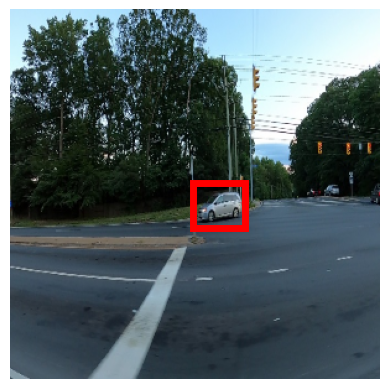

In [17]:
idx = 100
_image = plt.imread(image_paths[idx])
__image = preprocess_layer(_image)
_xmin, _ymin, _xmax, _ymax = bboxes[idx]
___xmin, __ymin, __xmax, __ymax = preprocess_bounding_box(_xmin, _ymin, _xmax, _ymax)
display_image_with_bounding_box(__image, ___xmin, __ymin, __xmax-___xmin, __ymax-__ymin)

i am not using tensorflow to preprocess bbox

In [18]:
bboxes_preprocessed = [preprocess_bounding_box(bbox[0], bbox[1], bbox[2], bbox[3]) for bbox in bboxes]
bboxes_preprocessed[0]

[124.40303909038461, 147.1670688663158, 144.95658464423076, 175.64325935]

In [19]:
def pipeline(path, label, bbox):
    raw = tf.io.read_file(path)
    img = tf.io.decode_jpeg(raw, channels=3)
    image_tf_preprocessed = preprocess_layer(img)
    bbox_preprocessed = bbox / 299
    return image_tf_preprocessed, (label, bbox_preprocessed)

Creating validation data set

In [20]:
from sklearn.model_selection import train_test_split
Xtrain_paths, Xvalid_paths, ytrain_labels, yvalid_labels, ytrain_bbox, yvalid_bbox = train_test_split(image_paths, labels, bboxes_preprocessed, test_size=0.1, random_state=42)

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((Xtrain_paths, ytrain_labels, ytrain_bbox))
train_dataset = train_dataset.map(pipeline)
train_dataset = train_dataset.batch(32)


In [22]:
valid_dataset = tf.data.Dataset.from_tensor_slices((Xvalid_paths, yvalid_labels, yvalid_bbox))
valid_dataset = valid_dataset.map(pipeline)
valid_dataset = valid_dataset.batch(32)

In [23]:
a,b = next(iter(valid_dataset.take(1)))
print(f"{a.shape}, {b[0].shape},{b[1].shape}")

(32, 299, 299, 3), (32,),(32, 4)


In [24]:
b[1][0]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>

Model

In [25]:
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

# output of class
cls_out = tf.keras.layers.Dense(1, activation="sigmoid", name="label_output")(avg)

# output of boundingbox
bbox_out = tf.keras.layers.Dense(4, name="bounding_box_output")(avg)

model = tf.keras.Model(inputs=base_model.input, outputs=[cls_out, bbox_out])

model.compile(loss=["binary_crossentropy", "mse"],
              optimizer="Adam")

In [26]:
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=10)
model.save("../model")

Epoch 1/10
29/29 [==============================] - 458s 16s/step - loss: 0.2334 - label_output_loss: 0.1835 - bounding_box_output_loss: 0.0498 - val_loss: 2.2364 - val_label_output_loss: 1.9912 - val_bounding_box_output_loss: 0.2452
Epoch 2/10
29/29 [==============================] - 450s 16s/step - loss: 0.0702 - label_output_loss: 0.0523 - bounding_box_output_loss: 0.0179 - val_loss: 0.8227 - val_label_output_loss: 0.1634 - val_bounding_box_output_loss: 0.6593
Epoch 3/10
29/29 [==============================] - 449s 16s/step - loss: 0.0558 - label_output_loss: 0.0346 - bounding_box_output_loss: 0.0212 - val_loss: 1.4564 - val_label_output_loss: 1.2329 - val_bounding_box_output_loss: 0.2235
Epoch 4/10
29/29 [==============================] - 559s 19s/step - loss: 0.0206 - label_output_loss: 0.0084 - bounding_box_output_loss: 0.0122 - val_loss: 0.4933 - val_label_output_loss: 0.3891 - val_bounding_box_output_loss: 0.1042
Epoch 5/10
29/29 [==============================] - 597s 20s/ste

INFO:tensorflow:Assets written to: ../model\assets


<Axes: >

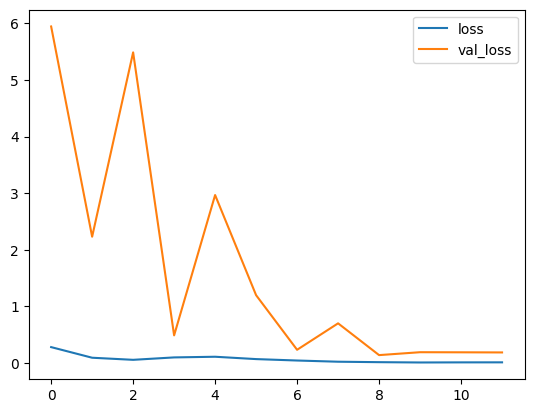

In [35]:
import pandas as pd
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()

# Testing

In [77]:
testImg_path = r"..\dataset\raw\data\testing_images\vid_5_26580.jpg"

test_img = tf.io.read_file(testImg_path)
test_img = tf.io.decode_jpeg(test_img)
test_img.shape


TensorShape([380, 676, 3])

In [78]:
test_img_preprocess = preprocess_layer(test_img)
test_img_preprocess.shape

TensorShape([299, 299, 3])

In [79]:
pred_cls, pred_bbox = model(tf.expand_dims(test_img_preprocess, axis=0))

In [80]:
print("car" if pred_cls > 0.5 else "No Object")

car


In [81]:
xmin_pred, ymin_pred, xmax_pred, ymax_pred = pred_bbox[0]

In [82]:
xmin_pred, ymin_pred, xmax_pred, ymax_pred = xmin_pred * 299,ymin_pred * 299, xmax_pred*299, ymax_pred*299

In [83]:
xmin_pred, ymin_pred, xmax_pred, ymax_pred

(<tf.Tensor: shape=(), dtype=float32, numpy=125.38233>,
 <tf.Tensor: shape=(), dtype=float32, numpy=126.48032>,
 <tf.Tensor: shape=(), dtype=float32, numpy=184.67818>,
 <tf.Tensor: shape=(), dtype=float32, numpy=182.35535>)

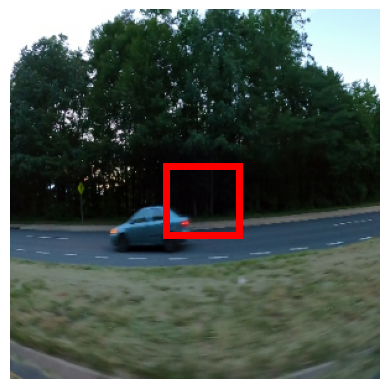

In [84]:
display_image_with_bounding_box(test_img_preprocess, xmin_pred, ymin_pred, xmax_pred-xmin_pred, ymax_pred-ymin_pred)

In [85]:
def testing_pipeline(path):
    test_img = tf.io.read_file(path)
    test_img = tf.io.decode_jpeg(test_img)
    test_img_preprocess = preprocess_layer(test_img)
    pred_cls, pred_bbox = model(tf.expand_dims(test_img_preprocess, axis=0))
    if pred_cls > 0.5:
        xmin_pred, ymin_pred, xmax_pred, ymax_pred = pred_bbox[0]
        xmin_pred, ymin_pred, xmax_pred, ymax_pred = xmin_pred * 299,ymin_pred * 299, xmax_pred*299, ymax_pred*299
        display_image_with_bounding_box(test_img_preprocess, xmin_pred, ymin_pred, xmax_pred-xmin_pred, ymax_pred-ymin_pred)
        print("Car detected")
    else:
        plt.figure()
        plt.imshow(test_img_preprocess)
        plt.axis('off')
        plt.show()
        print("No object found")


In [86]:
testing_pipeline("/content/drive/MyDrive/Dataset/car-object-detection/raw/testing_images/vid_5_28420.jpg")

NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: /content/drive/MyDrive/Dataset/car-object-detection/raw/testing_images/vid_5_28420.jpg : The system cannot find the path specified.
; No such process [Op:ReadFile]